# Model Verification Notebook

This notebook provides a lightweight verification of the QSVM and VQC
pipelines used in this project. Computationally expensive components
are intentionally limited to small subsets to ensure reproducibility
and fast execution.

This notebook is meant for validation, not final benchmarking.


In [12]:
# ===== Execution guards =====
RUN_QSVM = False        # Quantum kernel SVM (very expensive)
RUN_VQC = True         # Variational quantum classifier
MAX_QSVM_SAMPLES = 200  # Hard cap for safety

# Reduced training for verification
VQC_STEPS = 20
VQC_BATCH_SIZE = 10
VQC_LAYERS = 2

import numpy as np
np.random.seed(42)


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("training_observables.csv", header=None)
# Column name mapping (from reference notebook)
header_list = {
    0 : 'number',
    1 : 'eos_type',
    2 : 'mean_pt',
    3 : 'dndy',
    4 : 'v2',
    5 : 'v3',
    6 : 'v4',
    7 : 'v5',
    8 : 'psi2',
    9 : 'psi3',
    10 : 'psi4',
    11 : 'psi5',
    12 : 'ptspec_bin0',
    13 : 'ptspec_bin1',
    14 : 'ptspec_bin2',
    15 : 'ptspec_bin3',
    16 : 'ptspec_bin4',
    17 : 'ptspec_bin5',
    18 : 'ptspec_bin6',
    19 : 'ptspec_bin7',
    20 : 'ptspec_bin8',
    21 : 'ptspec_bin9',
    22 : 'ptspec_bin10',
    23 : 'ptspec_bin11',
    24 : 'ptspec_bin12',
    25 : 'ptspec_bin13',
    26 : 'ptspec_bin14',
    27 : 'v2_ptbin0',
    28 : 'v2_ptbin1',
    29 : 'v2_ptbin2',
    30 : 'v2_ptbin3',
    31 : 'v2_ptbin4',
    32 : 'v2_ptbin5',
    33 : 'v2_ptbin6',
    34 : 'v2_ptbin7',
    35 : 'v2_ptbin8',
    36 : 'v2_ptbin9',
    37 : 'v2_ptbin10',
    38 : 'v2_ptbin11',
    39 : 'v2_ptbin12',
    40 : 'v2_ptbin13',
    41 : 'v2_ptbin14',
    42 : 'v3_ptbin0',
    43 : 'v3_ptbin1',
    44 : 'v3_ptbin2',
    45 : 'v3_ptbin3',
    46 : 'v3_ptbin4',
    47 : 'v3_ptbin5',
    48 : 'v3_ptbin6',
    49 : 'v3_ptbin7',
    50 : 'v3_ptbin8',
    51 : 'v3_ptbin9',
    52 : 'v3_ptbin10',
    53 : 'v3_ptbin11',
    54 : 'v3_ptbin12',
    55 : 'v3_ptbin13',
    56 : 'v3_ptbin14',
    57 : 'v4_ptbin0',
    58 : 'v4_ptbin1',
    59 : 'v4_ptbin2',
    60 : 'v4_ptbin3',
    61 : 'v4_ptbin4',
    62 : 'v4_ptbin5',
    63 : 'v4_ptbin6',
    64 : 'v4_ptbin7',
    65 : 'v4_ptbin8',
    66 : 'v4_ptbin9',
    67 : 'v4_ptbin10',
    68 : 'v4_ptbin11',
    69 : 'v4_ptbin12',
    70 : 'v4_ptbin13',
    71 : 'v4_ptbin14',
    72 : 'v5_ptbin0',
    73 : 'v5_ptbin1',
    74 : 'v5_ptbin2',
    75 : 'v5_ptbin3',
    76 : 'v5_ptbin4',
    77 : 'v5_ptbin5',
    78 : 'v5_ptbin6',
    79 : 'v5_ptbin7',
    80 : 'v5_ptbin8',
    81 : 'v5_ptbin9',
    82 : 'v5_ptbin10',
    83 : 'v5_ptbin11',
    84 : 'v5_ptbin12',
    85 : 'v5_ptbin13',
    86 : 'v5_ptbin14'
}


# rename columns (same mapping as reference)
dataset = dataset.rename(columns=header_list)
dataset = dataset.drop(["number"], axis=1)

dataset = dataset.to_numpy()

Y = dataset[:, 0].astype(int)
X = dataset[:, 1:]

print("Full dataset:", X.shape, Y.shape)


Full dataset: (22575, 85) (22575,)


In [14]:
x_0 = X[Y == 0]
x_1 = X[Y == 1]
y_0 = Y[Y == 0]
y_1 = Y[Y == 1]

x_train_0, _, y_train_0, _ = train_test_split(
    x_0, y_0, test_size=0.5, random_state=42
)
x_train_1, _, y_train_1, _ = train_test_split(
    x_1, y_1, test_size=0.5, random_state=42
)

num_sample = min(MAX_QSVM_SAMPLES, len(x_train_0), len(x_train_1))

X_train = np.concatenate((x_train_0[:num_sample], x_train_1[:num_sample]))
Y_train = np.concatenate((y_train_0[:num_sample], y_train_1[:num_sample]))

print("Verification training set:", X_train.shape)


Verification training set: (400, 85)


In [15]:
important_features_id = np.array([0, 4, 5])  # eos_type, v2, v3

X_train = X_train[:, important_features_id]
print("Features used:", X_train.shape[1])


Features used: 3


In [16]:
import pennylane as qml

n_qubits = X_train.shape[1]
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))


In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def kernel_matrix(A, B):
    return np.array([[kernel(a, b) for b in B] for a in A])

if RUN_QSVM:
    print("Running QSVM verification...")
    svm = SVC(kernel=kernel_matrix)
    svm.fit(X_train, Y_train)
    preds = svm.predict(X_train)
    print("QSVM training accuracy:", accuracy_score(preds, Y_train))
else:
    print("QSVM skipped (RUN_QSVM = False)")


QSVM skipped (RUN_QSVM = False)


In [18]:
import torch
from torch.nn.functional import relu

dev_var = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    qml.templates.AngleEmbedding(x, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))


In [19]:
def hinge_loss(preds, targets):
    return relu(1 - preds * targets)

def train_vqc():
    params = torch.tensor(
        np.random.random((VQC_LAYERS, n_qubits, 3)),
        requires_grad=True
    )
    bias = torch.tensor(0.0, requires_grad=True)

    opt = torch.optim.Adam([params, bias], lr=0.1)
    loss_hist = []

    for step in range(VQC_STEPS):
        idx = np.random.choice(len(X_train), VQC_BATCH_SIZE)
        Xb = torch.tensor(X_train[idx])
        yb = torch.tensor(Y_train[idx], dtype=torch.float32)

        opt.zero_grad()
        preds = torch.stack([quantum_model(x, params) + bias for x in Xb])
        loss = torch.mean(hinge_loss(preds, yb))
        loss.backward()
        opt.step()

        loss_hist.append(loss.item())

    return loss_hist


In [20]:
if RUN_VQC:
    loss_history = train_vqc()
    print("Final loss:", loss_history[-1])
else:
    print("VQC skipped (RUN_VQC = False)")


Final loss: 0.6


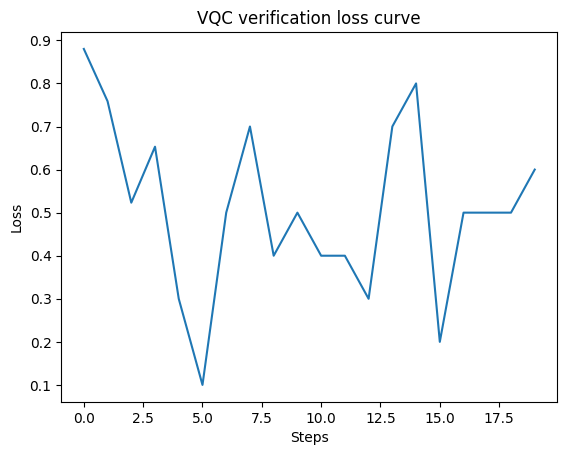

In [21]:
import matplotlib.pyplot as plt

if RUN_VQC:
    plt.plot(loss_history)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("VQC verification loss curve")
    plt.show()


**Interpretation:**  
The noisy but responsive loss curve indicates successful training of the
variational quantum classifier on a reduced QCD observable set.
This behavior is expected for shallow circuits and small batch sizes and
serves as functional validation of the model pipeline.
